# Pharmacophore Tutorial

The Pharmacophore-Toolkit is used to generate simple pharmacophore models. Final models are then rendered in PyMOL. The main steps in the Pharmacophore-Toolkit include molecules in 3D conformation, generating features, and outputting the results in .pml format. Examples of the .pml can be found [here](https://pymolwiki.org/index.php/Pml) or in this [blog post](https://www.blopig.com/blog/2017/01/using-pml-scripts-to-generate-pymol-images/).

Pharmacophore models can be built using crystal structures, docking poses, or SMILES strings. Crystal structures and docking poses make the Pharmacophore-Toolkit more straightforward, as the molecules are already in a 3D conformation. However, using SMILES string would require the generation of 3D conformation and alignment. Examples can be seen on the [RDKit blog](https://greglandrum.github.io/rdkit-blog/posts/2023-02-24-using-feature-maps.html). This tutorial uses a variation of the blog to fit the Pharmacophore-Toolkit python API.

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolAlign
import datamol as dm
from pharmacophore import Pharmacophore, Draw, View

## Dataset

This tutorial will use serotonin, psilocin, and mescaline as examples. All three binds to the Serotonin 5HT-2A receptor.

In this example, the molecules will be given as a dictionary in a name:SMILES pair. Each pair is then extracted into a separate list containing the SMILES string and the molecule name. The molecules can be visualized for confirmation.

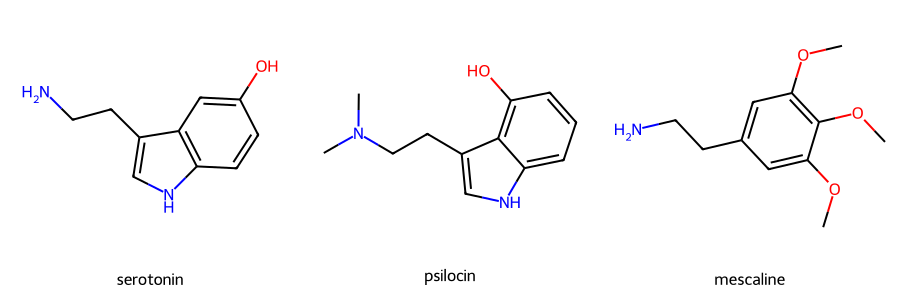

In [2]:
molecules = {"serotonin": "C1=CC2=C(C=C1O)C(=CN2)CCN",
             "psilocin": "CN(C)CCc1c[nH]c2cccc(O)c12",
             "mescaline": "O(c1cc(cc(OC)c1OC)CCN)C"}

mol_smi = [x for x in molecules.values()]
mol_name = [x for x in molecules.keys()]

mols = [Chem.MolFromSmiles(x) for x in mol_smi]
dm.viz.to_image(mols, mol_name)

## Generating Conformations
The 3D conformation can now be generated. For this example, a randomseed is given to ensure reproducibility.

In [3]:
mols = [Chem.AddHs(m) for m in mols]
ps = AllChem.ETKDGv3()
ps.randomSeed = 42
for m in mols:
    AllChem.EmbedMolecule(m,ps)

Once the 3D conformations have been generated, the molecules can be aligned. This is done using RDKit's Open3D align implementation. The alignment results can also output the RMSD score between the alignments. In this case, the serotonin molecule is used as the "base" for alignment. The resulting RMSD score gives an indication of the alignment results.

In [4]:
aligned = []

for x in mols:
    mol_aligned = rdMolAlign.GetO3A(x,mols[0])
    aligned.append(mol_aligned.Align())

# print(aligned)  # Optional. Will display a list of RMSD alignment score.

#### Optional
Because the molecules in this tutorial were rendered from SMILES strings, the 3D conformation will need to be saved. In this case, the conformation will be saved in .sdf format. This is done as follows:

In [5]:
for mol, name in zip(mols, mol_name):
    w = Chem.SDWriter(f"data/{name}.sdf")
    w.write(mol)
    w.close()

### Checking Conformation
Molecule conformation can be checked from the generated .sdf script above. Or the molecule conformation can be generated in 2D.

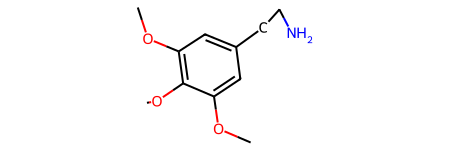

In [6]:
mols_noH = [Chem.RemoveHs(m) for m in mols]  # remove hydrogens for clarity.
mols_noH[2]

## Count Pharmacophores
Pharmacophores for each molecule can be generated and displayed as a DataFrame. To generate the table, initialize the Pharmacophore() class. By default, the Pharmacophore-Toolkit features will be set to use "default" methods. The Pharmacophore-Toolkit can also utilize RDKit feature sets by setting the feature param to "rdkit" or a custom feature set given in a dictionary format.

Once initialized, the to_df() method can be used. This method requires a list of molecules in Chem.Mol format and a list of the molecule name. The to_df() method also contains a "features" param that, if given, will override the param given upon Pharmacophore initialization. Again, "default", "rdkit", or a custom feature set in a dictionary format can be given. The generated table will display the number of matches to the given features in a DataFrame.

In [7]:
pharm = Pharmacophore()

df = pharm.to_df(mols_noH, mol_name)
df

,serotonin,psilocin,mescaline
Donor,3,2,1
Aromatic,2,2,1
Acceptor,0,1,3
Hydrophobe,0,3,3


#### Optional—Custom Features
If the "default" or "RDKit" features are not suitable for a project, users can set their own features. This requires a dictionary in 'feature_name':[SMARTS string] format. An example is given to identify all aromatic carbon atoms.

In [8]:
custom_feat = {'aromatic': ['c']}

custom_df = pharm.to_df(mols, mol_name, features=custom_feat)
custom_df

,serotonin,psilocin,mescaline
aromatic,8,8,6


In [9]:
pharm.features

{'aromatic': ['c']}

### Checking Features
Features used for a given model can be dispalyed using the feature_types() method.
Output default features. Can be used to output features associated with rdkit using the "features" param.

**NOTE:** Setting the feature types will overwrite the stored value. In this case, it is set to the custom_feat dictionary from above. In this example, the Pharmacophore() class will be reinitialized to use the default features.

In [10]:
pharm = Pharmacophore()
print(pharm.feature_types())

Default features: 
('Donor', 'Acceptor', 'Aromatic', 'Hydrophobe')


## Generate Pharmacophore Features
The following script will generate pharmacophore features based on a query molecule. This will take the molecule with the 3D conformaiton generated above and output a list of lists, containing the feature type, matching atom index, and the XYZ position. The features for the serotonin molecule is given as an example.

Again, the calc_pharm contains a "features" param that can modify the type of features for a molecule. As none is given at for this method or at the initialization of the Pharmacophore class, it will utilize default features.

In [11]:
# default
pharma = pharm.calc_pharm(mols_noH[0])
pharma

[['Donor', (9,), -0.9046174520168838, -2.235699615827842, 0.13645934200480056],
 ['Donor', (12,), 2.949925200279259, -0.15648413497184238, 1.2254205073233995],
 ['Donor', (6,), -2.5995394084260526, 2.931207478597561, -0.5905278269049035],
 ['Aromatic',
  (0, 1, 2, 3, 4, 5),
  -1.8583650464904398,
  0.2926900071440297,
  -0.1871054571985934],
 ['Aromatic',
  (2, 3, 7, 8, 9),
  -0.384216675975982,
  -1.2654866328983938,
  -0.21240652662909393]]

## Render Pharmacophore Features

The pharmacophore-toolkit contains a View() class to quickly render the molecules and their pharmacophores in a Jupyter notebook. This requires calling the View() class and the view() method. The parameters includes an RDKit molecule or a list of RDKit molecules and the calculated pharmacophores genereated from calc_pharm().

Additional parameters includes lables and window to label the pharmacophores and adjust the py3dmol window size, respectively.

**NOTE:** This method only works in Jupyter Notebook!

In [12]:
v = View()
single = mols_noH[0]
v.view(mols_noH, pharma, labels=True, window=(500, 500))

interactive(children=(Dropdown(description='Select:', options=(('Molecule 1', 0), ('Molecule 2', 1), ('Molecul…

**NOTE:** Notice that the interactive window includes a dropdown box. The pharmacophores drawn only correspond to serotonin (the first molecule). This is because the calculated pharmacophores were only generated for serotonin. For users that want a list of molecules and pharmacophores to cycle through, the pharmacophores must be calculated for each molecule. This can be done as follows:

In [13]:
pharma = []
for x in mols_noH:
    calc = pharm.calc_pharm(x)
    pharma.append(calc)
# pharma # To check the list of pharmacophores

In [14]:
v = View()
single = mols_noH[0]
v.view(mols_noH, pharma, labels=True, window=(500, 500))

interactive(children=(Dropdown(description='Select:', options=(('Molecule 1', 0), ('Molecule 2', 1), ('Molecul…

## Output Pharmacophore Features

As of now, py3Dmol does not include a screenshot feature. Rendering the pharmacophores for each molecule may be easier in pyMOL. The calculated pharmacophore features can be saved as a .pml file and then opened in pyMOL directly with the molecules (in .sdf or .mol2 formate). This will allow users to render the images in higher quality and save the 3D orientation based on user preferences.

In [15]:
pharm.output_features(savepath='data/pharma.pml')

Number of features: 8
Feature visualization script written to data/pharma.pml.


## Generate 2D Image
Pharmacophores can also be highlighted on the molecule in 2D. This is done using the Draw() class. Much of the parameters are the same as those used in the Pharmacophore() class. The query molecule will be drawn and atoms matching the pharmacophore sets will be highlighted in the corresponding color.

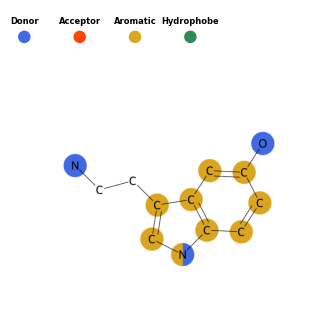

In [16]:
draw = Draw()
draw.draw_pharm(mols_noH[0])

#### Optional Color Options
Additionally, the colors on the 2D images can be modified by providing a dictionary for the color parameter in draw_pharm(). The dictionary should be in feature:color format. The feature must match the style given. i.e. same capitalization, spelling, etc. In this example, the custom_feat contains "aromatic" in lower case.

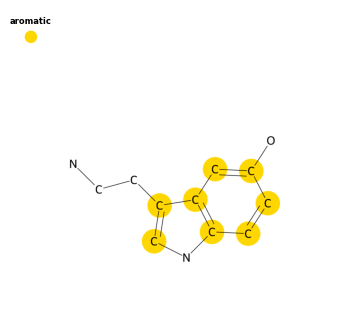

In [16]:
draw = Draw(features=custom_feat)
colors = {"aromatic":'gold'}
draw.draw_pharm(mols_noH[0], color=colors)